# 11. Bayesian History Matching technique (advanced use)

In [7]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from torchmetrics import MeanSquaredError, R2Score

from GPErks.constants import DEFAULT_RANDOM_SEED, DEFAULT_TMP_OUTFILE_DIR
from GPErks.gp.data.dataset import Dataset
from GPErks.gp.experiment import GPExperiment
from GPErks.gp.mean import LinearMean
from GPErks.perks.history_matching import Wave
from GPErks.serialization.path import posix_path
from GPErks.train.emulator import GPEmulator
from GPErks.utils.array import get_minmax
from GPErks.utils.plotting import get_col, interp_col
from GPErks.utils.random import set_seed
from GPErks.utils.sampling import Sampler

In [8]:
# Enforce reproducibility
seed = DEFAULT_RANDOM_SEED
set_seed(seed)

In [9]:
# Load experimental values (mean and variance) you aim to match
data_dir = posix_path(os.getcwd(), "data", "example_10")
expdata = {}
with open(Path(data_dir) / "expdata.json", "r") as f:
    expdata = json.load(f)
exp_mean = [val["mean"] for val in expdata.values()]
exp_var = [val["var"] for val in expdata.values()]

In [11]:
# Load dataset
datasets = Dataset.build_from_file(
    posix_path(os.getcwd(), "data", "datasets", "Stefano_8p_sham.json")
)
active_features = list(expdata.keys())

In [12]:
# Train list of univariate emulators (one for each feature to match)
device = "cpu"
emulators = []
for feature in active_features:
    dataset = datasets[feature]
    likelihood = GaussianLikelihood()
    mean = LinearMean(degree=1, input_size=dataset.input_size, bias=True)
    covar = ScaleKernel(MaternKernel(ard_num_dims=dataset.input_size))
    metrics = [MeanSquaredError(), R2Score()]

    experiment = GPExperiment(
        dataset, likelihood, mean, covar, metrics=metrics, seed=seed
    )

    emulator = GPEmulator(experiment, device)
    emulator.train_auto()
    emulators.append(emulator)

INFO:2025-05-16 17:23:15,923:emulator:train_auto:L205: Training emulator...
INFO:2025-05-16 17:23:16,168:emulator:train_auto:L207: Trained emulator.
INFO:2025-05-16 17:23:16,169:emulator:train_auto:L209: Saving model...
INFO:2025-05-16 17:23:16,171:emulator:train_auto:L214: Saved model.
INFO:2025-05-16 17:23:16,173:emulator:train_auto:L205: Training emulator...
INFO:2025-05-16 17:23:16,319:emulator:train_auto:L207: Trained emulator.
INFO:2025-05-16 17:23:16,319:emulator:train_auto:L209: Saving model...
INFO:2025-05-16 17:23:16,320:emulator:train_auto:L214: Saved model.
INFO:2025-05-16 17:23:16,322:emulator:train_auto:L205: Training emulator...
INFO:2025-05-16 17:23:16,429:emulator:train_auto:L207: Trained emulator.
INFO:2025-05-16 17:23:16,429:emulator:train_auto:L209: Saving model...
INFO:2025-05-16 17:23:16,430:emulator:train_auto:L214: Saved model.
INFO:2025-05-16 17:23:16,433:emulator:train_auto:L205: Training emulator...
INFO:2025-05-16 17:23:16,639:emulator:train_auto:L207: Train

In [13]:
xlabels = dataset.x_labels
minmax = get_minmax(dataset.X_train)

waveno = 1  # number of iteration we are at (wave id if you want)
cutoff = 3.0  # threshold value for the implausibility criterion
maxno = 1  # explained below
# The univariate GPE of each output feature will give for each point x_i a specific implausibility measure.
# With the current implausibility criterion, for each x_i we take the maximum implausibility across all the output
# features. With maxno=1, the maximum is calculated across all the output features (i.e., till the last worse
# implausibility measure). If maxno=2 --> till the previous-to-last worse implausibility measure and so on.
# With this criterion, the worse-performing emulator (the output feature which is the least well captured) will
# dominate the entire analysis and thus determine if a point is non-implausible or implausible

w = Wave(
    emulator=emulators,
    Itrain=minmax,
    cutoff=cutoff,
    maxno=maxno,
    mean=exp_mean,
    var=exp_var,
)  # instantiate the wave object

In [14]:
sampler = Sampler(design="lhs", dim=dataset.X_train.shape[1], seed=seed)
n_samples = 100000
X = sampler.sample(
    n_samples,
    l_bounds=list(minmax[:, 0]),
    u_bounds=list(minmax[:, 1]),
)

        #POINTS
TESTS    100000
IMP       99878
NIMP        122
PERC   0.1220 %


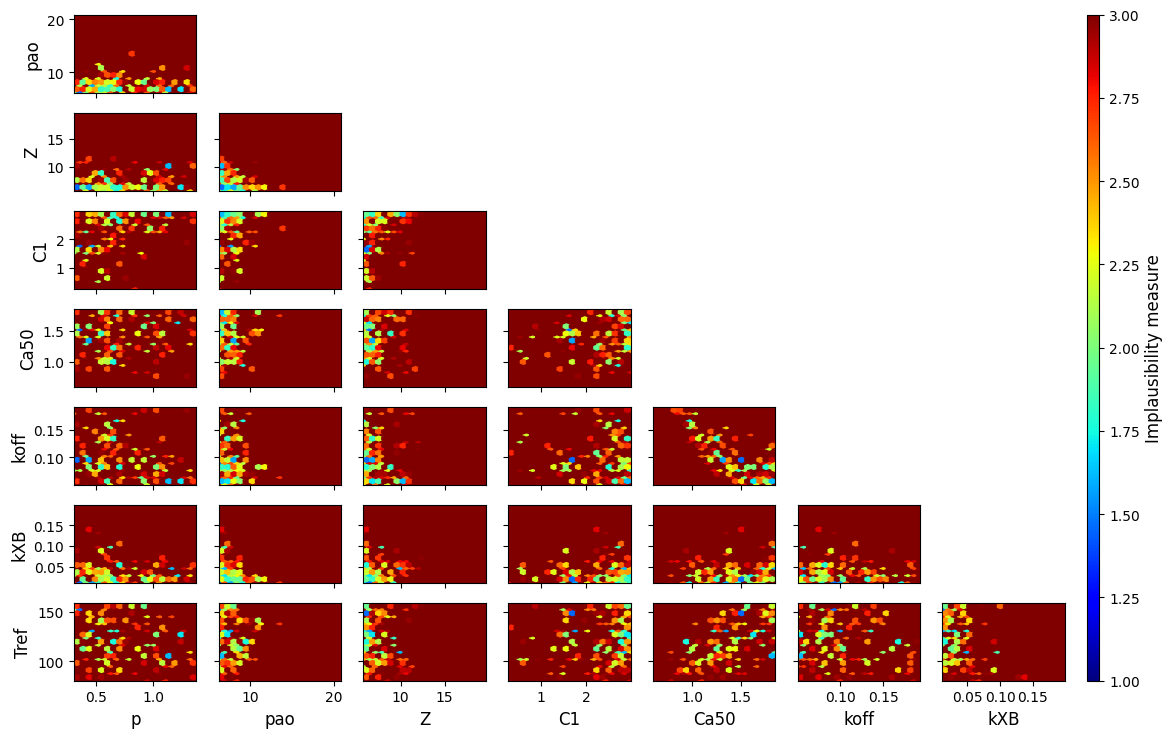

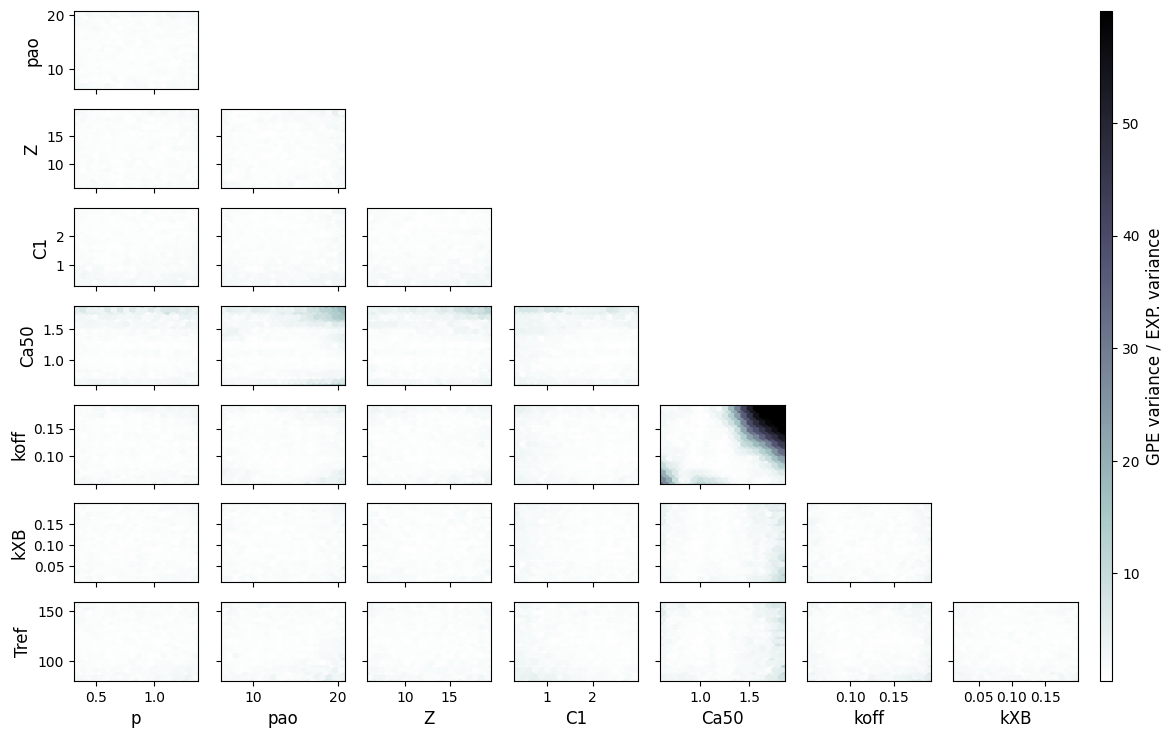

In [15]:
# Run one iteration of HM, which is: apply the implausibility criterion to detect regions of non-implausible
# and of implausible points starting from the initial samples in X
w.find_regions(X)
w.print_stats()  # show statistics about the two obtained spaces
w.plot_wave(xlabels=xlabels, display="impl")  # plot the current wave of history matching (impl. measure plot)
w.plot_wave(xlabels=xlabels, display="var")  # we can also check the accuracy of the GPEs for the current wave
# note: if we add the filepath=<path_to_file> flag, plots will be saved and not displayed

In [16]:
# How to continue on the next wave in 5 steps
#
# (0) Save an exact copy of the wave. We always recommend saving each wave right on completion before manipulating
# its internal structure as you might need it later for other purposes (see Appendix - A2)
outfiles_dir = Path(DEFAULT_TMP_OUTFILE_DIR)
outfiles_dir.mkdir(parents=True, exist_ok=True)

w0 = w.copy()
w0.print_stats()
w0.save(outfiles_dir / f"wave_{waveno}.json")

# (1) From the current non-implausible region, select points to be simulated and points to be used as tests
# for the next wave
n_tests = 10000  # number of TEST points we want for the next wave
n_simuls = 128  # number of current NIMP points we want to simulate to augment training dataset for the next wave
n_avail_nimps = len(
    w0.nimp_idx
)  # we currently have available only this number of NIMP points
if n_tests + n_simuls > n_avail_nimps:  # if they are not enough
    n_total_points = n_tests + n_simuls
    w.augment_nimp(
        n_total_points
    )  # use 'cloud technique' to generate new NIMP points starting from existing ones

        #POINTS
TESTS    100000
IMP       99878
NIMP        122
PERC   0.1220 %


INFO:2025-05-16 17:25:57,891:history_matching:augment_nimp:L132: 
Requested points: 10128
Available points: 122
Start searching...
INFO:2025-05-16 17:25:57,892:history_matching:augment_nimp:L142: [Iteration: 0 ] Found: 122   (  1.20%) | Missing: 10006
INFO:2025-05-16 17:25:57,903:history_matching:augment_nimp:L183: [Iteration: 1 ] Found: 169   (  1.67%) | Missing: 9959 
INFO:2025-05-16 17:25:57,918:history_matching:augment_nimp:L183: [Iteration: 2 ] Found: 245   (  2.42%) | Missing: 9883 
INFO:2025-05-16 17:25:57,932:history_matching:augment_nimp:L183: [Iteration: 3 ] Found: 342   (  3.38%) | Missing: 9786 
INFO:2025-05-16 17:25:57,947:history_matching:augment_nimp:L183: [Iteration: 4 ] Found: 493   (  4.87%) | Missing: 9635 
INFO:2025-05-16 17:25:57,972:history_matching:augment_nimp:L183: [Iteration: 5 ] Found: 748   (  7.39%) | Missing: 9380 
INFO:2025-05-16 17:25:58,013:history_matching:augment_nimp:L183: [Iteration: 6 ] Found: 1108  ( 10.94%) | Missing: 9020 
INFO:2025-05-16 17:25:

In [17]:
# Get the requested datasets
X_simul, X_test = w.get_nimps(n_simuls)

# We now have all the necessary data to run the next wave: a dataset to simulate to augment the training dataset
# and build new emulators, and new TEST points to be evaluated with the new emulators. Saving the data to files.
np.savetxt(outfiles_dir / f"X_simul_{waveno}.txt", X_simul, fmt="%.6f")
np.savetxt(outfiles_dir / f"X_test_{waveno}.txt", X_test, fmt="%.6f")

w.print_stats()  # quick check on TESTS, IMP, and NIMP sets' sizes after augmentation

# (2) Simulate the selected points X_simul
# (3) Add the simulated points and respective results to the training dataset used in the previous wave
# (3) Train GPEs on the new, augmented training dataset
# (4) Start a new wave of HM, where the initial parameter space to be split into non-implausible and
# implausible regions is no more a Latin Hypercube design but is now the non-implausible region obtained
# (and augmented) in the previous wave (i.e., X_test)

        #POINTS
TESTS    110006
IMP       99878
NIMP      10128
PERC   9.2068 %


In [ ]:
from GPErks.constants import DEFAULT_TMP_OUTFILE_DIR
# How to continue on the next wave in 5 steps
#
# (0) Save an exact copy of the wave. We always recommend saving each wave right on completion before manipulating
# its internal structure as you might need it later for other purposes (see Appendix - A2)
outfiles_dir = Path(DEFAULT_TMP_OUTFILE_DIR)
outfiles_dir.mkdir(parents=True, exist_ok=True)
w0 = w.copy()
w0.print_stats()
w0.save(os.path.join(outfiles_dir, f"wave_{waveno}.json"))

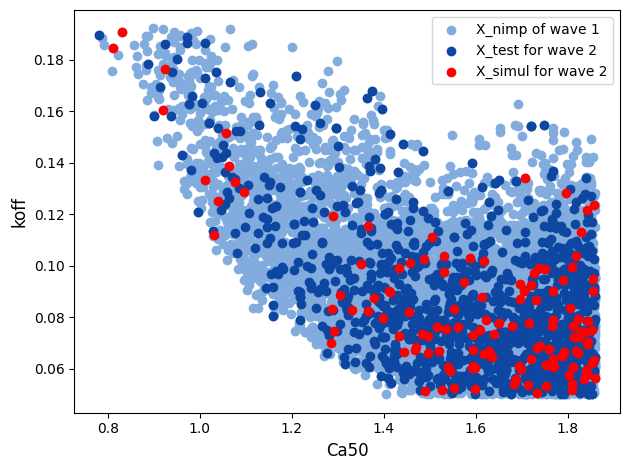

In [18]:
# Appendix
#
# (A1) Visual check on the datasets generated for the next wave
X_nimp = w.NIMP
X_test = np.loadtxt(outfiles_dir / f"X_test_{waveno}.txt", dtype=float)
X_simul = np.loadtxt(outfiles_dir / f"X_simul_{waveno}.txt", dtype=float)

# We will inspect only 2 dimensions of the full 8D parameter space to keep it simple
param = [4, 5]  # select 2 dimensions
subset_idx = list(
    np.random.randint(0, X_test.shape[0], size=10 * X_simul.shape[0])
)  # select an example portion

colors = interp_col(get_col("blue"), 4)  # getting some blue colour variants

# Plotting current wave NIMP + next wave TEST + next wave SIMUL
fig, axis = plt.subplots(1, 1)
axis.scatter(
    X_nimp[:, param[0]],
    X_nimp[:, param[1]],
    fc=colors[1],
    ec=colors[1],
    label=f"X_nimp of wave {waveno}",
)
axis.scatter(
    X_test[subset_idx, param[0]],
    X_test[subset_idx, param[1]],
    fc=colors[-1],
    ec=colors[-1],
    label=f"X_test for wave {waveno+1}",
)
axis.scatter(
    X_simul[:, param[0]],
    X_simul[:, param[1]],
    fc="r",
    ec="r",
    label=f"X_simul for wave {waveno+1}",
)
axis.set_xlabel(xlabels[param[0]], fontsize=12)
axis.set_ylabel(xlabels[param[1]], fontsize=12)
axis.legend()
fig.tight_layout()
plt.show()  # TEST + SIMUL points for NEXT wave are all within NIMP space CURRENT wave

In [19]:
# (A2) Loading a wave object
# You can load a wave object by providing the same data used to instantiate the wave (emulator, Itrain, cutoff,
# maxno, mean, var). This is normally done when you need to re-run the wave differently. Alternatively, you can load
# the wave object with no arguments. This is normally done when you need to examine the wave internal structure.
# Let's try loading with no arguments.
w = Wave()
w.load(Path(outfiles_dir) / f"wave_{waveno}.json")
w.print_stats()  # notice that TESTS, IMP, and NIMP sets' sizes are the same as pre-augmentation

# You can get a list of all wave object attributes by printing:
# print(w.__dict__.keys())

# Noteworthy attributes are:
# W.I: implausibility measure obtained for each point in the test set
# W.PV: percentage emulator variance over experimental variance at each point (given as a fraction)
# W.NIMP: non-implausible region
# W.nimp_idx: indices of the initial test set which resulted to be non-implausible
# W.IMP: implausible region
# W.imp_idx: indices of the initial test set which resulted to be implausible
# W.simul_idx: indices of W.NIMP that were selected to be simulated for the next wave
# W.nsimul_idx: indices of W.NIMP which were not selected for simulations
# (the respective points will appear in the test set of the next wave instead)

# The original test set is not stored as an attribute to save space. However, this information can still be
# retrieved from the stored attributes as:
X_test = w.reconstruct_tests()
(np.equal(X_test, X)).all()
# the test set of first wave was the LHD we generated initially in this script

        #POINTS
TESTS    100000
IMP       99878
NIMP        122
PERC   0.1220 %


np.True_